#Module 6 - Audio Properties and Processing
In this Module 6 notebook, we study AI and NLP techniques for audio (or speech) data analysis. Similar to text, audio is unstructured data, but with several  unique properties. 

**Sound** is the origin of audio, "mechanical vibration that passes through a medium", where the vibrations are identified as sound waves that passes through mediums such as air, water, metal etc. 

**Audio** is an electrical representation of "sound" that is within the audible range of humans, 20 – 20,000 Hz. Audio is also persistent, sound that is produced, recorded or processed as electric signals. 

**Audio is recorded in analog or digital format**. **Analog audio** is when the analog signals is directly recorded on the media, as an AC voltage representation that coincides with the sound.

**Digtal audio** is a digital representation of the analog audio signal. It is an approximation of discrete samples of varying amplitudes that are stacked next to each other to generate a representation of the analog signal. The analog to digital conversion consists of two steps: 1) **sampling** - to produce a continuous-valued discrete-time signal, 2) **quantization** - replace each sample value with an approximate from a given discrete set. This means the quality of the digital audio is lower than the original analog audio. 

In **audio NLP**, we primarily work with digital audio which is already in numerical format but "unstructured" due to the continuous-valued discrete-time signals. 

Digital audio can be easily transcribed into text and then text NLP techniques applied on this transcribed text. But this also means we lose **audio-only properties** of the conversation or dialog, such as increased pitch, tonality or intense emotions like sobbing, crying or laughing. 

Therefore it is important to study Audio NLP techniques that can be applied on the digital audio prior to transcription to text and the application of text NLP. 

The latter part of the notebook presents a case study of a contact centre audio recording and the application of audio and text NLP techniques. But we begin with the Audio NLP techniques.  

##Installing libraries

In [ ]:
!pip install noisereduce
!pip install SpeechRecognition pydub
!pip install transformers
!pip install git+https://github.com/LIAAD/yake 
!pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 132 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.1 MB/s 
     |████████████████████████████████| 182 kB 8.8 MB/s 
     |████████████████████████████████| 7.6 MB 56.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-4uxcd993
  Running command git clone -q https://github.com/LIAAD/yake /tmp/pip-req-build-4uxcd993
     |████████████████████████████████| 132 kB 21.5 MB/s 
  Created wheel for yake: filename=yake-0.4.8-py2.py3-none-any.whl size=62600 sha256=63222c808201f08b57d27cf5f1cdaaba5f4b2e3b4349b11d38e2381a9675b0d4
  Stor

##Import library

In [ ]:
#libraries for google drive authentication
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#python libraries for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
from matplotlib.pyplot import figure

# Importing NLTK libraries for text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#load audio processing libraries
import librosa
import librosa.display
import noisereduce as nr
from noisereduce.generate_noise import band_limited_noise
from pydub import AudioSegment
import speech_recognition as sr
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
from gtts import gTTS

#Import sklearn and other AI libraries
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from transformers import pipeline
import yake

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Loading a sample recording.

Let's load a sample audio recording. 

In [ ]:
#authenticate with you google drive credentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# This is the file ID of the data set, this will download the datafile from the shared location
sample_audio_id = '16oBDI3QI4sMdWJk4o6OW6RI3zkQ4awX4'
sample_audio_file = drive.CreateFile({'id':sample_audio_id})
sample_audio_file.GetContentFile('sample_audio.wav')

The "Audio" package from IPython display tools creates an audio player to listen to the audio files. We can play/pause, and change volume and playback speed here.

In [ ]:
file_path = "sample_audio.wav"
Audio(file_path)

Let' use the [Librosa Python library](https://librosa.org/doc/latest/index.html) for the initial audio processing .

##Sample rate

As noted earlier, digital audio is "sampled", and the number of samples per second is called the "sampling rate". The sampling rate in audio data is similar in concept to the resolution of an image. The higher the better, and  closer to the quality of analog audio. Sample rates generally range from 8000-44100 Hz.

Librosa load() function load an audio file as a floating point time series.
The load function automatically resamples to default sampling rate of 22050, to preserve the native sampling rate of the file, we have to use sr=None

In [ ]:
signal, sample_rate = librosa.load(file_path, sr=None)

The load() function returns a tuple with audio time series (y) and a sample rate (sr).



In [ ]:
print("Sample rate  :", sample_rate)
print("Signal Length:", len(signal))
print("Duration     :", len(signal)/sample_rate, "seconds")

Sample rate  : 16000
Signal Length: 49920
Duration     : 3.12 seconds


The "signal" variable loads and decodes the audio stream as a time series, represented as a one-dimensional NumPy floating point array

In [ ]:
print("Type  :", type(signal))
print("Signal: ", signal)
print("Shape :", signal.shape)

Type  : <class 'numpy.ndarray'>
Signal:  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.5258789e-04
 -3.0517578e-05 -3.0517578e-05]
Shape : (49920,)


Let's resample the audio file, at half the current rate and twice the current rate.

In [ ]:
Audio(signal, rate=sample_rate/2)

In [ ]:
Audio(signal, rate=sample_rate*2)

##Waveform

A waveform is a curve showing the amplitude of the soundwave (y-axis) at time T (x-axis). Here we use Librosa to plot the waveform.

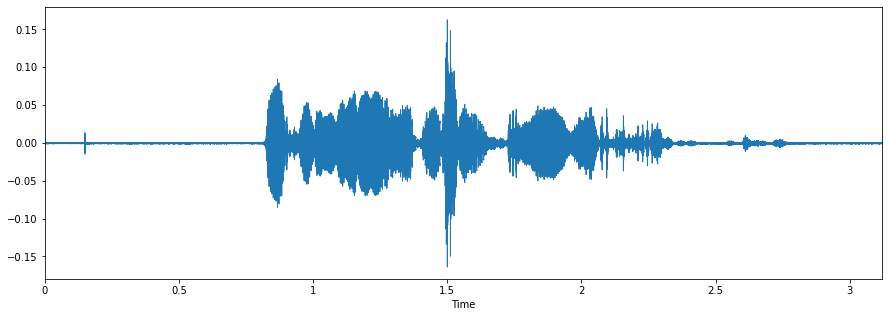

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(signal, sr=sample_rate)

The x-axis has been converted to time using the sample rate. If we plotted in matplotlib with plt.plot(y), we would get the same figure, but with the sample number on the x-axis instead of seconds.



##Frequency

Frequency is a measure of how many times the signal repeats itself (number of cycles) per second. It is difficult to notice frequency in the above graph, because audio (and human speech) are the combination of many different frequencies added together. Prior to frequency and pitch, let's examine pure tone.

Let's create a single tone at 500hz, and another at 5000hz.

In [ ]:
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)
clip_500hz = make_tone(500)
clip_5000hz = make_tone(5000)

In [ ]:
Audio(clip_500hz, rate=sample_rate)

In [ ]:
Audio(clip_5000hz, rate=sample_rate)

At 500 cycles per second and 16000 samples per second, we have 32 samples per cycle (16000/500), let's plot 2 cycles (or 64 samples)

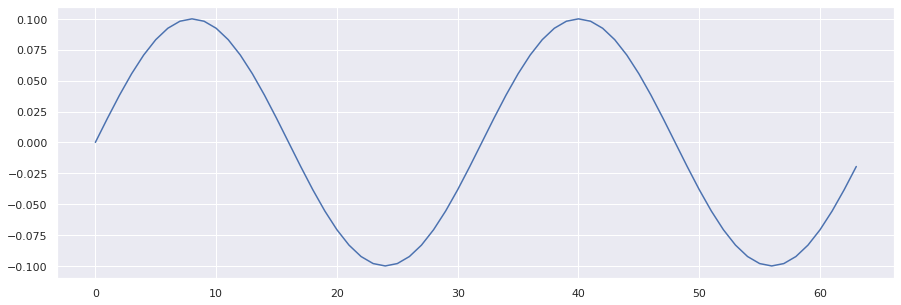

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(clip_500hz[0:64])

Below is the same for 5000hz. Here we get 16000/5000 which is 3.2 samples per cycle. Let's plot the same 64 samples, and we can see 20 cycles.

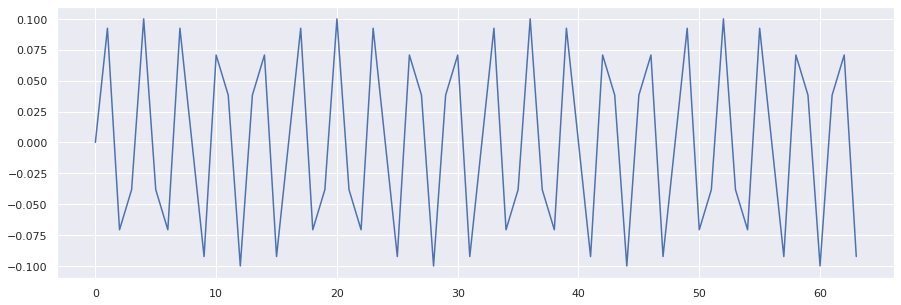

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(clip_5000hz[0:64])

This comparison helps us to understand that for high frequency audio we have to increase the sampling rate to ensure not just quality but also completeness of the sound capture. 

## Pitch

Pitch is a an audio (sound) property that makes it possible to judge sounds as "higher" and "lower" in the sense associated with musical melodies. In musical term, this is the human perception of frequency. 

Let's increase the frequency of the above tones by 500hz and see how this alters our auditory perception.

In [ ]:
clip_500_to_1000 = np.concatenate([make_tone(500), make_tone(1000)])
clip_5000_to_5500 = np.concatenate([make_tone(5000), make_tone(5500)])

In [ ]:
# first half of the clip is 500hz, 2nd is 1000hz
Audio(clip_500_to_1000, rate=sample_rate)

In [ ]:
# first half of the clip is 5000hz, 2nd is 5500hz
Audio(clip_5000_to_5500, rate=sample_rate)

Let's try to change the pitch of our audio clip.

In [ ]:
high_pitch = librosa.effects.pitch_shift(signal, sample_rate, n_steps=6) # how many (fractional) half-steps to shift y, here it is 6

In [ ]:
Audio(high_pitch,rate=sample_rate)

In [ ]:
low_pitch = librosa.effects.pitch_shift(signal, sample_rate, n_steps=-6) # how many (fractional) half-steps to shift y, here it is 4

In [ ]:
Audio(low_pitch,rate=sample_rate)

## Noise

In signal (and audio) processing, noise is a disturbance (unexpected or unknown modifications) to the original signal, caused due to the process of capturing, transmission, processing, or conversion. Noise does not carry useful information and should be discarded.

As our sample audio is free from noise, let's add some noise.

In [ ]:
noise = band_limited_noise(min_freq=1000, max_freq = 2000, samples=len(signal), samplerate=sample_rate)*10
signal_with_noise = signal+noise

In [ ]:
Audio(signal_with_noise,rate=sample_rate)

Let's plot the signal, with and without noise.

[Text(0.5, 1.0, 'With Noise')]

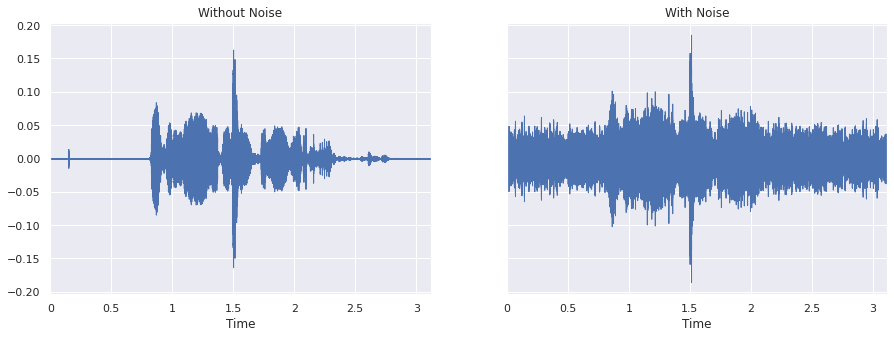

In [ ]:
fig, ax =  plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 5))
librosa.display.waveplot(signal, sr=sample_rate, ax=ax[0])
librosa.display.waveplot(signal_with_noise, sr=sample_rate, ax=ax[1])
ax[0].set(title='Without Noise')
ax[1].set(title='With Noise')

### Noise Removal

We can use the noisereduce library to remove noise. It works through spectral gating, which is by computing a spectrogram of a signal (and a noise signal) and estimating a noise threshold (or gate) for each frequency band of that signal/noise.

In [ ]:
signal_reduced_noise = nr.reduce_noise(y = signal_with_noise, sr=sample_rate, n_std_thresh_stationary=1.5,stationary=True)

In [ ]:
Audio(signal_reduced_noise,rate=sample_rate)

Let's plot all three version, notice how the noise removed is different to the original. This indicates there is always information loss to the original signal.

[Text(0.5, 1.0, 'Noise removed')]

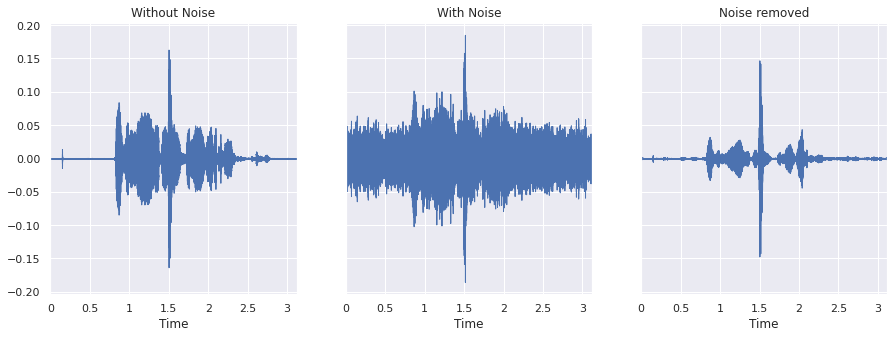

In [ ]:
fig, ax =  plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))
librosa.display.waveplot(signal, sr=sample_rate, ax=ax[0])
librosa.display.waveplot(signal_with_noise, sr=sample_rate, ax=ax[1])
librosa.display.waveplot(signal_reduced_noise, sr=sample_rate, ax=ax[2])
ax[0].set(title='Without Noise')
ax[1].set(title='With Noise')
ax[2].set(title='Noise removed')

##Speech to text

As you might notice, Audio NLP is not as advanced or mature as text NLP. 
"Speech to text" is the "shortcut" to apply advanced text NLP on audio data. 

Here we use the Python Speech recognition library. It provides access to several major speech-to-text services such as Microsoft Bing, Google, and IBM. Many of these services require subscription keys. Let's use Google speech to text which is free to use without a subscription.

In [ ]:
filename = file_path

# initialize the recognizer
r = sr.Recognizer()

# open the file
with sr.AudioFile(filename) as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source)
    # recognize (convert from speech to text)
    # Google Speech Recognition
    text = r.recognize_google(audio_data)
    print(text)

what we need is information


##Text to speech

Similarly, we can convert text to speech. For this purpose, we can use the gtts library.

In [ ]:
tts = gTTS("Let's try to use this library",lang='en')
tts.save('temp.wav')
sound_file = 'temp.wav'
Audio(sound_file, rate = 22050) 

#Case study - NLP in a Contact Centre

Now let's work through an end-to-end case study of all the NLP techniques we have learned in this course. 

We are using a sample call recording received at to call centre of Magellan Solutions, Philippines. The call recording is about cancelling a subscription.[link](https://www.magellan-solutions.com/)

Let's load the audio recording.

In [ ]:
# This is the file ID of the data set, this will download the datafile from the shared location
sample_audio_id = '1ITl16dPPVkiXV2DcM3VI17QlkZOwKiWM'
sample_audio_file = drive.CreateFile({'id':sample_audio_id})
sample_audio_file.GetContentFile('sample_call_center_recording.mp3')

In [ ]:
Audio(r"sample_call_center_recording.mp3")

As this is a larger audio clip, let's use a sophisticated speech-to-text service , [Azure speech studio](https://speech.microsoft.com/portal). 

Azure produce high-quality speech-to-text with segmentation and speaker separation. 

The following code loads the separated and segmented text data from the above audio recording.

In [ ]:
# This is the file ID of the data set, this will download the datafile from the shared location
call_transcription_id = '1-ZszxACZ512JSTFr7mPiLE28XKfC4yBo'
call_transcription_file = drive.CreateFile({'id':call_transcription_id})
call_transcription_file.GetContentFile('call_transcription.csv')

In [ ]:
transcription = pd.read_csv(r"call_transcription.csv")
display(transcription)

,segment_id,speaker_tag,segment_text
0,0,1,You have reached the essence of hargon. This i...
1,1,2,"Umm, well I bought. I got this from essence of..."
2,2,2,"Uh, 15 days? And so that is what I want wanted..."
3,3,2,"For what is it, $83 a month?"
4,4,1,OK.
...,...,...,...
69,69,2,"OK, alright."
70,70,1,"OK then. So, uh, is there anything else I can ..."
71,71,2,"No, that would be it."
72,72,1,OK then. So we value your business. Thank you ...


As you can see Azure has correctly identified there are two speakers and tagged them as speakers 1 and 2. 

The next steps should be familiar to you, as we apply text NLP techniques on this transcribed text. 

### Text pre-processing



In [ ]:
#lowercase
transcription["segment_text"]  = transcription["segment_text"].str.lower()

In [ ]:
#remove punctuations
# \w - A word character is a character a-z, A-Z, 0-9, including _ (underscore).
# \s - spaces between words
# ^  - for nagation
def remove_punctuations(text):
  text_new = re.sub(r"[^\w\s]",'',text)
  return text_new

transcription["segment_text"]  = transcription["segment_text"] .apply(remove_punctuations)

In [ ]:
#remove numbers
def remove_numbers(text):
  text_new = re.sub('\d+', '', text)
  return text_new

transcription["segment_text"]  = transcription["segment_text"] .apply(remove_numbers)

In [ ]:
#remove stopwords
# get the list of all stopwords from the library
stopword_list = stopwords.words('english')
# exclude not as a stopword
stopword_list.remove('not')
 
# A function to remove stopwords from a corpus
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stopword_list]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

transcription["segment_text"]  = transcription["segment_text"] .apply(remove_stop_words)

### Word Frequency Analysis



In [ ]:
#combining all the segments.
all_text = ' '.join(transcription['segment_text'])
text_splits = all_text.split()

In [ ]:
# Create a word frequency series. using pandas value_counts
word_frequency = pd.Series(text_splits).value_counts()

In [ ]:
#get top 20 words
word_frequency[:20]

ok              27
uh              13
know            11
give            11
us               9
product          9
paying           8
lake             7
call             7
thats            7
want             7
benefits         7
discount         7
umm              6
cant             6
subscription     6
like             6
im               6
employee         6
days             5
dtype: int64

### **Word frequency using a word cloud**

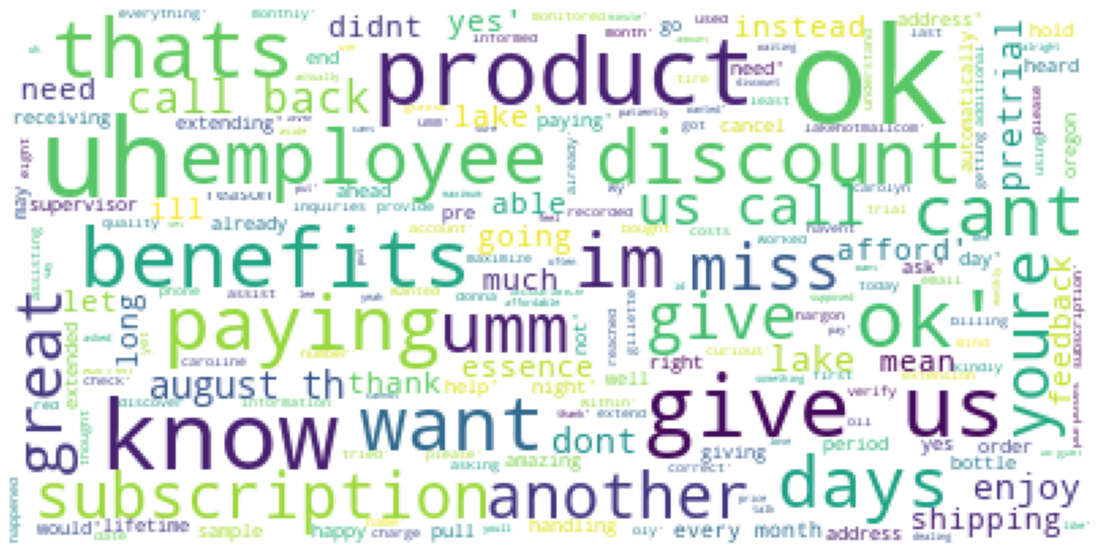

In [ ]:
corpus = list(transcription["segment_text"])
wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))
plt.figure(figsize=(20,10))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### n-gram Analysis

In [ ]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, range):
    
    # Create CountVectorizer object from sklearn library with bi-grams
    term_counts = CountVectorizer(ngram_range=(range, range), max_features=2000).fit(corpus)
    
    # Create BoW feature representation using word frequency
    document_term_matrix = term_counts.transform(corpus)

    # compute sum of words
    sum_words = document_term_matrix.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in term_counts.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

### **Bigrams (2-gram)**



In [ ]:
bigrams = get_ngrams(transcription["segment_text"].tolist(), range=2)

In [ ]:
# view the bi-grams
bigrams

[('give us', 8),
 ('employee discount', 6),
 ('us call', 5),
 ('call back', 5),
 ('august th', 5),
 ('miss lake', 4),
 ('pretrial another', 3),
 ('another days', 3),
 ('us feedback', 3),
 ('need give', 3),
 ('instead paying', 3),
 ('ok uh', 3),
 ('thats great', 3),
 ('every month', 3),
 ('want cancel', 2),
 ('didnt want', 2),
 ('know like', 2),
 ('cant afford', 2),
 ('im happy', 2),
 ('go ahead', 2),
 ('shipping address', 2),
 ('thank much', 2),
 ('uh miss', 2),
 ('youre not', 2),
 ('not know', 2),
 ('im extending', 2),
 ('th give', 2),
 ('gives benefits', 2),
 ('product dont', 2),
 ('dont need', 2),
 ('automatically receiving', 2),
 ('giving employee', 2),
 ('discount instead', 2),
 ('cant cant', 2),
 ('uh uh', 2),
 ('long want', 2),
 ('ok alright', 2),
 ('great uh', 2),
 ('ok thats', 2),
 ('month paying', 2),
 ('benefits product', 2),
 ('reached essence', 1),
 ('essence hargon', 1),
 ('hargon donna', 1),
 ('donna ill', 1),
 ('ill assisting', 1),
 ('assisting inquiries', 1),
 ('inquir

In [ ]:
# Convert bigrams to a dataframe with column names bi-gram and frequency.
bigrams_df = pd.DataFrame(bigrams)
bigrams_df.columns=["Bigram", "Freq"]


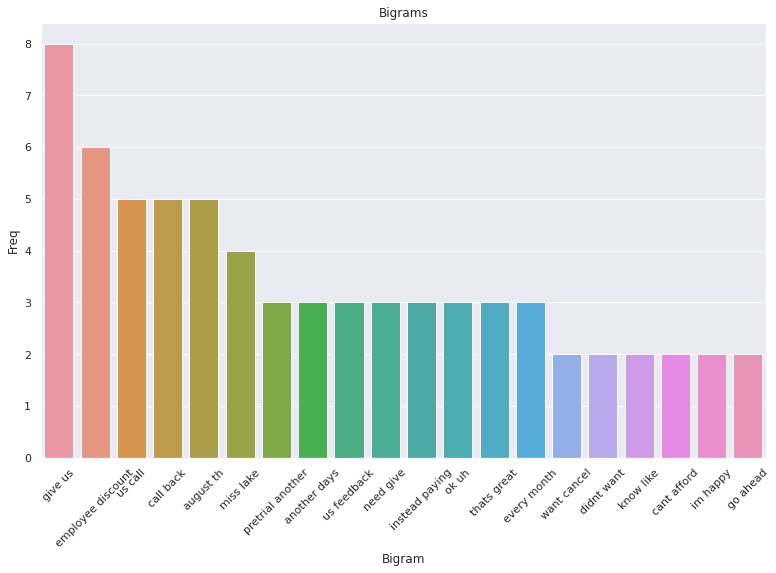

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bigram", y="Freq", data=bigrams_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.title('Bigrams')
plt.show()

### **Trigrams (3-gram)**

In [ ]:
trigrams = get_ngrams(transcription["segment_text"].tolist(), range=3)

Convert tri-grams to a dataframe with column names Trigram and frequency.

In [ ]:
trigrams_df = pd.DataFrame(trigrams)
trigrams_df.columns=["Trigram", "Freq"]

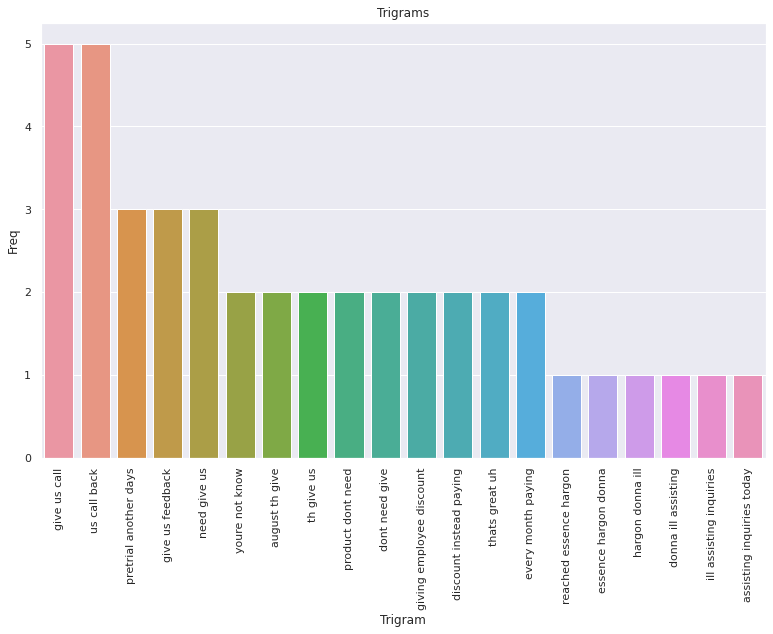

In [ ]:
# Barplot of most freq Trigrams
top_trigrams_to_show = 20
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Trigram", y="Freq", data=trigrams_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Trigrams')
plt.show()

### **Keyword Extraction**

Let's use [YAKE](https://github.com/LIAAD/yake) keyword extraction 

### **Yake keyword extraction - functions**

In [ ]:
def extract_kwrds(text,numOfKeywords = 30):
  language = "en"
  max_ngram_size = 3
  deduplication_thresold = 0.9
  deduplication_algo = 'seqm'
  windowSize = 1
  kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
  return kw_extractor.extract_keywords(text)

### **Yake keyword extraction - sample text**




In [ ]:
text = ' '.join(transcription['segment_text'])

In [ ]:
keywords = extract_kwrds(text,20)
print(keywords)

[('giving employee discount', 0.00010320759991962072), ('give employee discount', 0.00013850696719015652), ('employee discount employee', 0.00015213510779346002), ('employee discount discount', 0.00015534909117050484), ('discount employee discount', 0.00015534909117050484), ('call back august', 0.00016626228721578756), ('discount ill give', 0.0001942263766108673), ('call back automatically', 0.00020400607812549846), ('product gives benefits', 0.00020913112229383295), ('employee discount ill', 0.0002133562752688966), ('call back end', 0.00021688046805958902), ('lifetime employee discount', 0.00021944170647556117), ('employee discount lifetime', 0.00021944170647556117), ('maximum employee discount', 0.00022997222763444935), ('enjoy product gives', 0.00023045087046337447), ('extending pretrial august', 0.0002398357919480964), ('amazing product give', 0.00024074066708706286), ('miss lake dont', 0.00024313653055797995), ('gives benefits amazing', 0.00024519307843117496), ('call heard youre'

Let's highlight these keywords in the call recording. 

In [ ]:
from yake.highlight import TextHighlighter
from IPython.core.display import display, HTML
# Keyword Highlighter
th = TextHighlighter(max_ngram_size = 3, highlight_pre = '<span style="background-color: yellow;">', highlight_post= "</span>")
highlight = th.highlight(text,keywords)
display(HTML(highlight))

### Hugging Face - Text summarization

In [ ]:
summarization_pipeline = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
summary=summarization_pipeline(text, max_length=50, min_length=10, do_sample=False)[0]

In [ ]:
print(summary['summary_text'])

 Call recorded monitored quality assurance purposes may help umm well bought got essence oregon oil umm shipping handling handling handling costs sample want cancel order within uh days want wanted didnt want didnt want  want cancel subscription well umm thought getting sample


### Hugging Face - Sentiment Analysis



In [ ]:
sa_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def sentiment_extract(text):
  sentiment_dict = {'NEGATIVE':-1,'POSITIVE':+1}
  result = sa_pipeline(text)[0]
  print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
  out_score = sentiment_dict[result['label']]*round(result['score'], 4)
  return [out_score,result['label']]

In [ ]:
score = []
sentiment = []

for i,row in transcription.iterrows():
  output = sentiment_extract(row['segment_text'])
  sentiment.append(output[1])
  score.append(output[0])

transcription['sentiment'] =  sentiment
transcription['score'] =  score

label: NEGATIVE, with score: 0.9931
label: NEGATIVE, with score: 0.9929
label: NEGATIVE, with score: 0.9896
label: POSITIVE, with score: 0.9749
label: POSITIVE, with score: 0.9998
label: POSITIVE, with score: 0.9949
label: POSITIVE, with score: 0.9914
label: NEGATIVE, with score: 0.7204
label: POSITIVE, with score: 0.985
label: POSITIVE, with score: 0.9998
label: POSITIVE, with score: 0.9968
label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.9774
label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.9767
label: NEGATIVE, with score: 0.9719
label: NEGATIVE, with score: 0.7156
label: NEGATIVE, with score: 0.8322
label: NEGATIVE, with score: 0.9908
label: POSITIVE, with score: 0.9998
label: NEGATIVE, with score: 0.6629
label: NEGATIVE, with score: 0.9761
label: NEGATIVE, with score: 0.9353
label: NEGATIVE, with score: 0.9664
label: POSITIVE, with score: 0.961
label: POSITIVE, with score: 0.994
label: NEGATIVE, with score: 0.9547
label: NEGATIVE, with score: 0.

### Sentiment Analysis - Comparison 

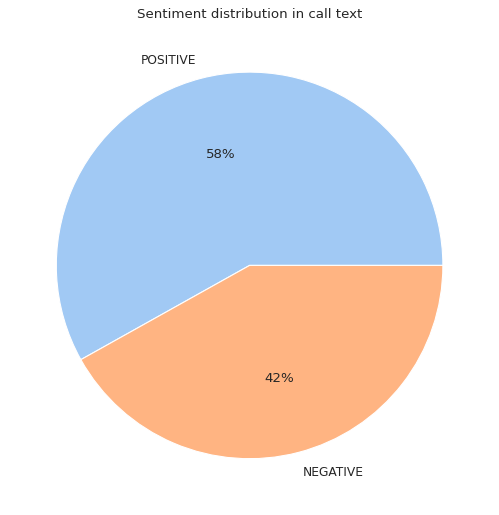

In [ ]:
# compare positive emotions with positive sentiment 
sentiment = transcription.sentiment.value_counts().rename_axis('sentiment').reset_index(name='counts')

colors = sns.color_palette('pastel')[0:5]
figure(figsize=(10, 8), dpi=80)
plt.title('Sentiment distribution in call text')
plt.pie(sentiment['counts'], labels = sentiment['sentiment'], colors = colors, autopct='%.0f%%')
plt.show()

Comparing customer and agent sentiment

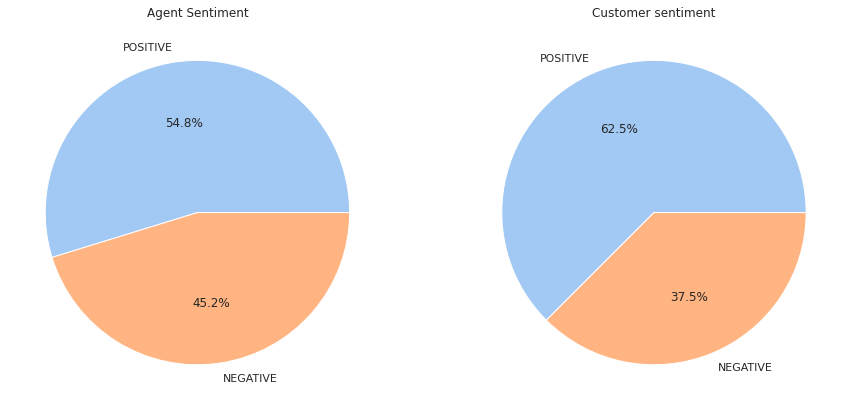

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot


agent_sentiment = transcription[transcription['speaker_tag']==1].sentiment.value_counts().rename_axis('sentiment').reset_index(name='counts')
customer_sentiment = transcription[transcription['speaker_tag']==2].sentiment.value_counts().rename_axis('sentiment').reset_index(name='counts')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,10)) #ax1,ax2 refer to your two pies

labels = agent_sentiment['sentiment']
values = agent_sentiment['counts']
ax1.pie(values,labels = labels,colors = colors,autopct = '%1.1f%%') #plot first pie
ax1.set_title("Agent Sentiment")

labels = customer_sentiment['sentiment']
values = customer_sentiment['counts']
ax2.pie(values,labels = labels,colors = colors,autopct = '%1.1f%%') #plot second pie
ax2.set_title('Customer sentiment')

fig.show()

### Sentiment Analysis - Trend

Let's examine how the sentiment trends or varies throughout the call. Here we will split the call into n segments and calculate mean sentiments to generate sentiment trends.

Let's split the call into 10 segments and get average sentiment scores.

In [ ]:
sentiment_averages = [round(np.mean(list(k)), 4) for k in np.array_split(transcription['score'], 10)]

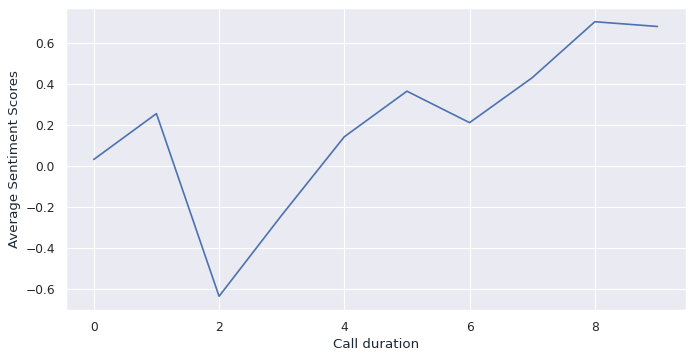

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(len(sentiment_averages))]
y = sentiment_averages
figure(figsize=(10, 5), dpi=80)
plt.plot(x, y)
plt.xlabel('Call duration', color='#1C2833')
plt.ylabel('Average Sentiment Scores', color='#1C2833')
plt.show()

Let's calculate the sentiment trend in the call.

In [ ]:
def linreg(X, Y):
    """
    return a,b in solution to y = ax + b such that root mean square distance between trend line and original points is minimized
    """
    N = len(X)
    Sx = Sy = Sxx = Syy = Sxy = 0.0
    for x, y in zip(X, Y):
        Sx = Sx + x
        Sy = Sy + y
        Sxx = Sxx + x*x
        Syy = Syy + y*y
        Sxy = Sxy + x*y
    det = Sxx * N - Sx * Sx
    return (Sxy * N - Sy * Sx)/det, (Sxx * Sy - Sx * Sxy)/det



def get_grad(x):
    a,b = linreg(range(len(x)),x)
    return [a,b]

In [ ]:
gradients = get_grad(sentiment_averages)

Let's plot the trend line in the same plot.

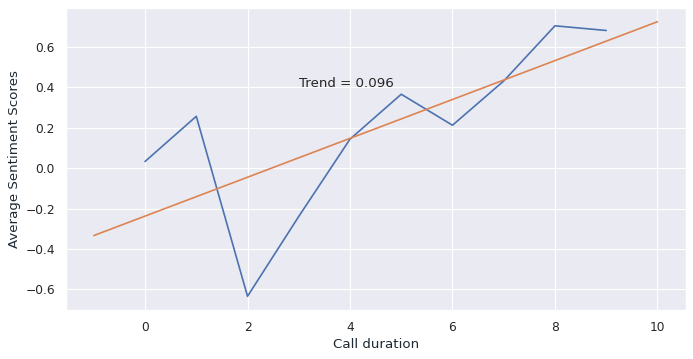

In [ ]:
import matplotlib.pyplot as plt
figure(figsize=(10, 5), dpi=80)
x = [i for i in range(len(sentiment_averages))]
y = sentiment_averages
plt.plot(x, y)


x = np.linspace(-1,10,len(sentiment_averages))
y = gradients[0]*x+gradients[1]

plt.plot(x, y)
plt.text(3, 0.4, 'Trend = '+str(round(gradients[0],3)), fontsize = 12)
plt.xlabel('Call duration', color='#1C2833')
plt.ylabel('Average Sentiment Scores', color='#1C2833')
plt.show()

### Sentiment Analysis - Trend of Agent vs Caller

Similarly we can calculate the agent's and customer's sentiment trends seperately as well.

In [ ]:
agent_sentiment_averages = [round(np.mean(list(k)), 4) for k in np.array_split(transcription[transcription['speaker_tag']==1]['score'], 10)]
customer_sentiment_averages = [round(np.mean(list(k)), 4) for k in np.array_split(transcription[transcription['speaker_tag']==2]['score'], 10)]
agent_gradients = get_grad(agent_sentiment_averages)
customer_gradients = get_grad(customer_sentiment_averages)

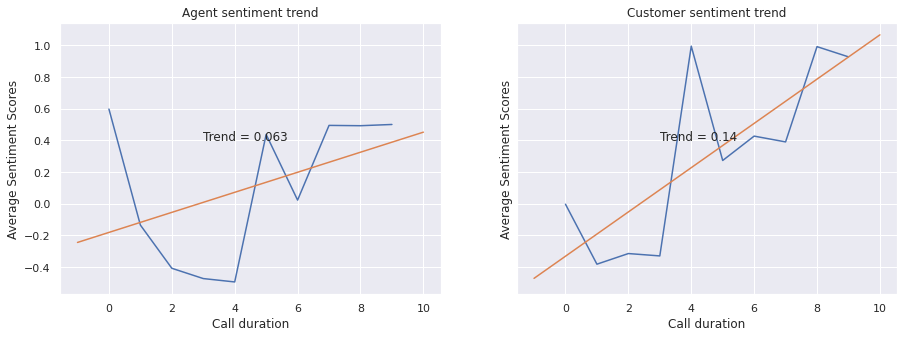

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),sharey=True) #ax1,ax2 refer to your two pies

x = [i for i in range(len(agent_sentiment_averages))]
y = agent_sentiment_averages
ax1.plot(x, y)
x = np.linspace(-1,10,len(agent_sentiment_averages))
y = agent_gradients[0]*x+agent_gradients[1]
ax1.plot(x, y)
ax1.text(3, 0.4, 'Trend = '+str(round(agent_gradients[0],3)), fontsize = 12)
ax1.set_title('Agent sentiment trend')
ax1.set_xlabel('Call duration')
ax1.set_ylabel('Average Sentiment Scores')

x = [i for i in range(len(customer_sentiment_averages))]
y = customer_sentiment_averages
ax2.plot(x, y)
x = np.linspace(-1,10,len(customer_sentiment_averages))
y = customer_gradients[0]*x+customer_gradients[1]
ax2.plot(x, y)
ax2.text(3, 0.4, 'Trend = '+str(round(customer_gradients[0],3)), fontsize = 12)
ax2.set_title('Customer sentiment trend')
ax2.set_xlabel('Call duration')
ax2.set_ylabel('Average Sentiment Scores')


plt.show()



----------------------------------------

End of OptusU_AIN_Module_6_AudioNLP.ipynb.